In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# 读取数据集
data = pd.read_csv('data.csv')

# 特征缩放
# 这里使用了标准化方法，将特征转换为均值为 0，方差为 1 的分布
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data.iloc[:, :-2].values)

# 分割特征和标签
X = X_scaled
sensors = data.iloc[:, -2].values  # 传感器
y = data.iloc[:, -1].values  # 标签

In [3]:
print(f"情绪类别: {[name for name, group in data.groupby(data.columns[-1])]}")

情绪类别: [0, 1, 2, 3, 4, 5, 6, 7]


In [4]:
# 将数据组织成多个时间步的序列
seq_length = 10  # 每个样本包含的时间步数
X_seq = []
y_seq = []
for name, group in data.groupby(data.columns[-1]):
    for i in range(0, group.iloc[:, :-2].values.shape[1], seq_length):
        chunk = group.iloc[:, :-2].iloc[:, i:i + seq_length]
        chunk = pd.concat([chunk, group.iloc[:, -2]], axis=1) # 带上传感器信息
        if chunk.shape[1] == seq_length + 1:
            y_seq.append(group.iloc[0, -1])
            X_seq.append(chunk.to_numpy())

In [6]:
X_seq[0]

array([[ 1.55,  1.55,  1.55,  1.55,  1.6 ,  1.55,  1.55,  1.55,  1.6 ,
         1.66,  1.  ],
       [22.77, 23.97, 26.37, 29.52, 32.65, 35.06, 38.24, 53.74, 73.86,
        63.15,  2.  ],
       [ 4.31,  4.31,  4.31,  4.31,  4.3 ,  4.3 ,  4.3 ,  4.3 ,  4.3 ,
         4.3 ,  3.  ],
       [43.07, 43.07, 43.05, 43.03, 42.98, 42.96, 42.92, 42.91, 42.92,
        42.97,  4.  ]])

In [4]:
assert len(X_seq) == len(y_seq)

In [5]:
# 分割训练集、验证集和测试集
# 划分训练集和临时集
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X_seq, y_seq, test_size=0.05, random_state=42)

# 再将临时集划分为验证集和测试集
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.1, random_state=42)

In [13]:
emotions = ["No Emotion ", "Anger ", "Hate ", "Grief ", "P-Love ", "R-Love ", "Joy ", "Reverence "]
emotions_zh = ["无情感 ", "生气 ", "仇恨 ", "悲伤 ", "亲情", "爱情", "玩笑", "敬畏"]
emotion_encoder = {emotion: i for i, emotion in enumerate(emotions)}
emotion_decoder = {i: emotion for i, emotion in enumerate(emotions)}

In [6]:
# 将数据转换为 PyTorch 张量并移动到 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [7]:
# 将数据转换为 PyTorch 张量
X_train_array = np.array(X_train) # 将列表转换为数组
y_train_array = np.array(y_train) # 将列表转换为数组
X_test_array = np.array(X_test) # 将列表转换为数组
y_test_array = np.array(y_test) # 将列表转换为数组
X_val_array = np.array(X_val) # 将列表转换为数组
y_val_array = np.array(y_val) # 将列表转换为数组
X_train_tensor = torch.tensor(X_train_array, dtype=torch.float32).to(device) # 用数组创建张量
y_train_tensor = torch.tensor(y_train_array, dtype=torch.int64).to(device)
X_test_tensor = torch.tensor(X_test_array, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_array, dtype=torch.int64).to(device)
X_val_tensor = torch.tensor(X_val_array, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val_array, dtype=torch.int64).to(device)

In [8]:
# 模型选择
# 这里使用了神经网络模型
class ImprovedBidirectionalLSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.1):
        super(ImprovedBidirectionalLSTMClassifier, self).__init__()
        self.lstm1 = nn.LSTM(input_dim, hidden_dim,
                             batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(hidden_dim * 2, hidden_dim, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        
        self.dropout1 = nn.Dropout(dropout)  # 添加dropout层
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout2 = nn.Dropout(dropout)  # 添加dropout层
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout3 = nn.Dropout(dropout)  # 添加dropout层
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        
        self.fc = nn.Linear(hidden_dim, output_dim)


    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out = self.fc1(out)
        out = self.dropout1(out)  # 应用dropout
        out = self.fc2(out)
        out = self.dropout2(out)  # 应用dropout
        out = self.fc3(out)
        out = self.dropout3(out)  # 应用dropout
        out = self.fc4(out)
        out = self.fc(out[:, -1, :])
        return out

input_dim = X_train_tensor.shape[-1]
hidden_dim = 1024
output_dim = 8  # 8个情绪类别

model = ImprovedBidirectionalLSTMClassifier(input_dim, hidden_dim, output_dim)
model = model.to(device)

In [9]:
# 定义批次的大小
batch_size = 128
learning_rate = 5e-5

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 初始化空列表以存储损失值
train_losses = []
val_losses = []
val_accuracies = []
val_epochs = []  # 记录验证的周期数
epoch = 0

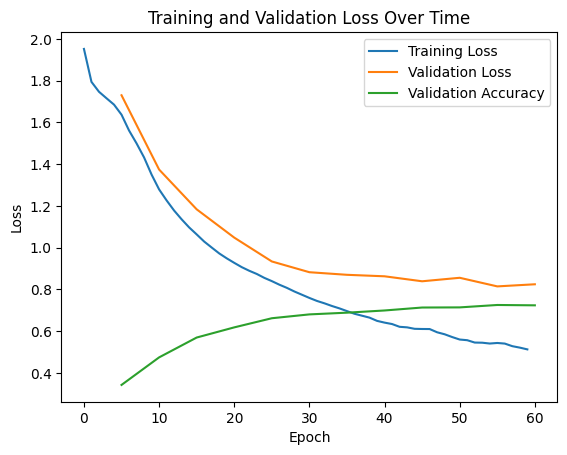

In [10]:
from IPython.display import clear_output, display

def validate(epoch):
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        val_losses.append(val_loss.item())
        _, predicted = torch.max(val_outputs, 1)
        val_accuracy = (predicted == y_val_tensor).sum().item() / len(y_val_tensor)
        val_accuracies.append(val_accuracy)
        val_epochs.append(epoch)

# 计算训练数据的总批次数
n_batches = len(X_train_tensor) // batch_size
# 如果训练数据不能被批次大小整除，需要增加一个批次
if len(X_train_tensor) % batch_size != 0:
    n_batches += 1

for epoch in range(epoch, epoch + 60):
    # 初始化一个变量来存储该周期的总损失值
    epoch_loss = 0
    # 用循环语句来遍历训练数据的切片
    for i in range(n_batches):
        model.train()
        # 获取第 i 个批次的数据
        X_batch = X_train_tensor[i * batch_size : (i + 1) * batch_size]
        y_batch = y_train_tensor[i * batch_size : (i + 1) * batch_size]
        # 对第 i 个批次的数据进行训练
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        # 将该批次的损失值累加到该周期的总损失值中
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

    # 计算该周期的平均损失值，并将其添加到列表中
    epoch_loss /= n_batches
    train_losses.append(epoch_loss)

    if (epoch + 1) % 5 == 0:
        validate(epoch + 1)
        
    # 绘制损失曲线
    clear_output(wait=True)  # 清除输出，等待下一次绘制
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_epochs, val_losses, label='Validation Loss')
    plt.plot(val_epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Time')
    plt.legend()
    plt.show()

In [12]:
# 模型评估
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
    _, y_pred = torch.max(y_pred_tensor, 1)
    accuracy = torch.sum(y_pred == torch.tensor(
        y_test).to(device)).item() / len(y_test)
    print('Accuracy:', accuracy)

    cm = confusion_matrix(y_test, y_pred.cpu().numpy())
    print('Confusion matrix:\n', cm)

    fpr, tpr, thresholds = roc_curve(y_test, y_pred.cpu().numpy(), pos_label=4)
    auc_value = auc(fpr, tpr)
    print('AUC value:', auc_value)

Accuracy: 0.7270455965021861
Confusion matrix:
 [[153   1   2   3  13   3   2   4]
 [  5 145   1  21   8   4   7   4]
 [ 20   5 151   2   7  11   7   4]
 [  8   8   8 163  14   2   4   5]
 [ 18   3   8   7 128  11   9  14]
 [ 10   7  18   9  19 109  23   6]
 [  2   7   6  14   9  12 146   4]
 [  8   0   3   8  13   3   3 169]]
AUC value: 0.5618677869212438


In [16]:
torch.save(model, 'model_70.pth')

In [9]:
# 加载整个模型
model1 = torch.load('model_70.pth')

In [10]:
model1.to(device)

ImprovedBidirectionalLSTMClassifier(
  (lstm1): LSTM(11, 1024, batch_first=True, bidirectional=True)
  (lstm2): LSTM(2048, 1024, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (dropout2): Dropout(p=0.1, inplace=False)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (dropout3): Dropout(p=0.1, inplace=False)
  (fc4): Linear(in_features=1024, out_features=1024, bias=True)
  (fc): Linear(in_features=1024, out_features=8, bias=True)
)

In [14]:
rights = []
wrongs = []
with torch.no_grad():
    y_pred_tensor = model1(X_test_tensor)
    _, y_pred = torch.max(y_pred_tensor, 1)
    accuracy = torch.sum(y_pred == torch.tensor(
        y_test).to(device)).item() / len(y_test)
    for i in range(len(y_test)):
        if y_test[i] == y_pred[i]:
            rights.append(emotion_decoder[int(y_test[i])])
        if y_test[i] != y_pred[i]:
            wrongs.append({emotion_decoder[int(y_test[i])]: emotion_decoder[int(y_pred[i])]})
            # print(f"正确的: {emotion_decoder[int(y_test[i])]} 得到的: {emotion_decoder[int(y_pred[i])]}")

In [15]:
unique_values, counts = np.unique(np.array(rights), return_counts=True)

# 计算每个值的占比
percentages = counts / len(rights)

# 打印结果
for value, percentage in zip(unique_values, percentages):
    print(f"值 {value} 的占比为 {percentage:.2%}")

值 Anger  的占比为 12.46%
值 Grief  的占比为 14.00%
值 Hate  的占比为 12.97%
值 Joy  的占比为 12.54%
值 No Emotion  的占比为 13.14%
值 P-Love  的占比为 11.00%
值 R-Love  的占比为 9.36%
值 Reverence  的占比为 14.52%


In [16]:
# 初始化一个字典来记录每个正确情感标签下，预测结果的数量
results_count = {}

# 遍历数据，统计结果数量
for pair in wrongs:
    true_emotion = list(pair.keys())[0]  # 获取正确情感标签
    predicted_emotion = pair[true_emotion]  # 获取预测情感标签

    # 如果该正确情感标签还没有记录在结果字典中，则初始化该情感标签的预测结果字典
    if true_emotion not in results_count:
        results_count[true_emotion] = {}

    # 记录预测结果数量
    if predicted_emotion not in results_count[true_emotion]:
        results_count[true_emotion][predicted_emotion] = 1
    else:
        results_count[true_emotion][predicted_emotion] += 1

# 输出结果
for true_emotion, predicted_results in results_count.items():
    print(f"正确情感标签 '{true_emotion}' 的预测结果分布:")
    total_count = sum(predicted_results.values())
    for predicted_emotion, count in predicted_results.items():
        percentage = (count / total_count) * 100
        print(f"  预测为 '{predicted_emotion}': {percentage:.2f}% ({count}次)")

正确情感标签 'R-Love ' 的预测结果分布:
  预测为 'Hate ': 19.57% (18次)
  预测为 'Grief ': 9.78% (9次)
  预测为 'Reverence ': 6.52% (6次)
  预测为 'Joy ': 25.00% (23次)
  预测为 'P-Love ': 20.65% (19次)
  预测为 'Anger ': 7.61% (7次)
  预测为 'No Emotion ': 10.87% (10次)
正确情感标签 'Grief ' 的预测结果分布:
  预测为 'Anger ': 16.33% (8次)
  预测为 'P-Love ': 28.57% (14次)
  预测为 'Hate ': 16.33% (8次)
  预测为 'Joy ': 8.16% (4次)
  预测为 'No Emotion ': 16.33% (8次)
  预测为 'Reverence ': 10.20% (5次)
  预测为 'R-Love ': 4.08% (2次)
正确情感标签 'No Emotion ' 的预测结果分布:
  预测为 'Grief ': 10.71% (3次)
  预测为 'P-Love ': 46.43% (13次)
  预测为 'R-Love ': 10.71% (3次)
  预测为 'Reverence ': 14.29% (4次)
  预测为 'Hate ': 7.14% (2次)
  预测为 'Anger ': 3.57% (1次)
  预测为 'Joy ': 7.14% (2次)
正确情感标签 'Joy ' 的预测结果分布:
  预测为 'No Emotion ': 3.70% (2次)
  预测为 'Grief ': 25.93% (14次)
  预测为 'Hate ': 11.11% (6次)
  预测为 'R-Love ': 22.22% (12次)
  预测为 'P-Love ': 16.67% (9次)
  预测为 'Anger ': 12.96% (7次)
  预测为 'Reverence ': 7.41% (4次)
正确情感标签 'Anger ' 的预测结果分布:
  预测为 'No Emotion ': 10.00% (5次)
  预测为 'Grief ': 42.00% (21次)

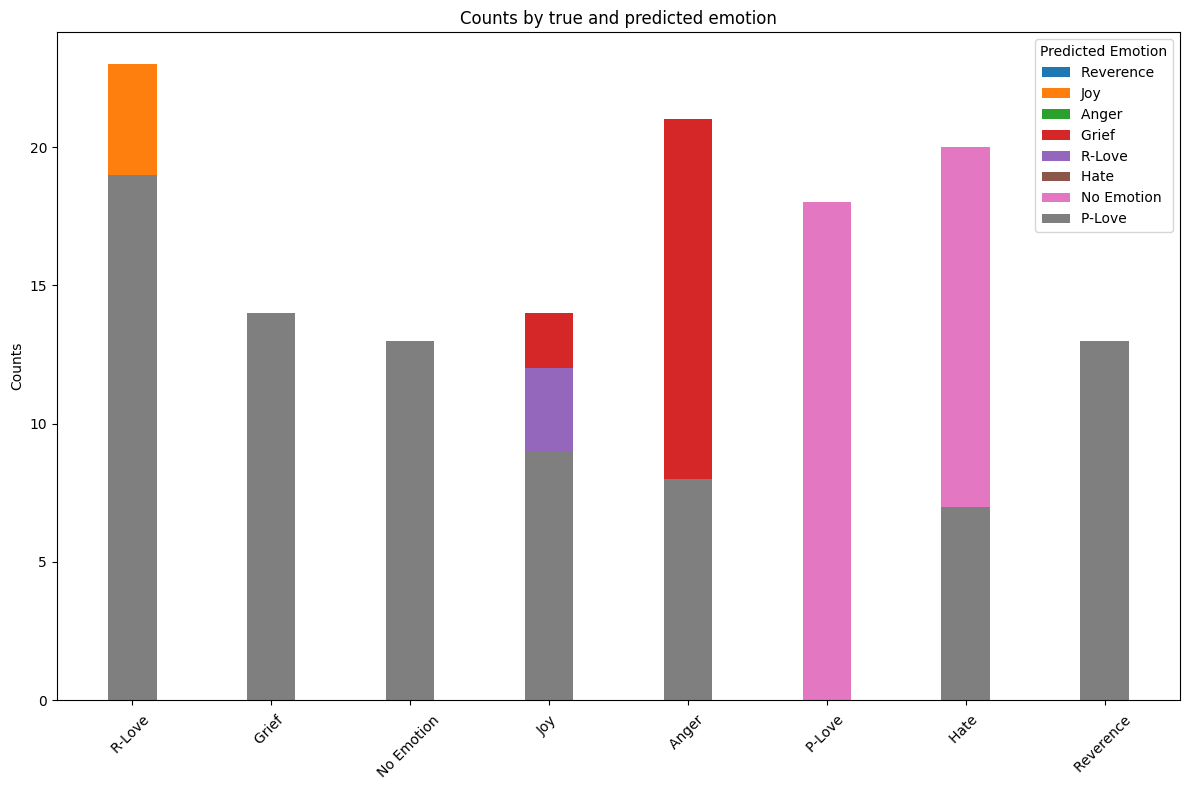

In [17]:
# 重新整理数据以适应绘制需求
labels = list(results_count.keys())
predicted_labels = set([pred for results in results_count.values() for pred in results])
predicted_counts = {label: {pred: 0 for pred in predicted_labels} for label in labels}

# 填充预测计数
for true_emotion, predictions in results_count.items():
    for predicted_emotion, count in predictions.items():
        predicted_counts[true_emotion][predicted_emotion] = count

# 准备绘图数据
x = range(len(labels))  # x轴位置
width = 0.35  # 柱状图的宽度

fig, ax = plt.subplots(figsize=(12, 8))

for idx, predicted_label in enumerate(predicted_labels):
    counts = [predicted_counts[label][predicted_label] for label in labels]
    ax.bar(x, counts, width, label=predicted_label)

# 添加图表元素
ax.set_ylabel('Counts')
ax.set_title('Counts by true and predicted emotion')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(title='Predicted Emotion')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()